In [1]:
#!pip install spacy

In [2]:
#!pip install num2words

In [3]:
#!python -m spacy download es_core_news_sm

In [4]:
##ELABORACION DEL PROYECTO 1

In [5]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import matplotlib.pyplot as plt
import spacy
from num2words import num2words
import re
# Cargar modelo de idioma español
nlp = spacy.load('es_core_news_sm')
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='spanish')

In [6]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('HotelsReviews.csv', sep=',', encoding = 'utf-8', index_col=0)
# Asignación a una nueva variable de los datos leidos
data_t=data

In [7]:
data_t['words'] = data_t['review_text'].apply(lambda x: x.split())

data_t.describe()

,rating,label
count,5000.00000,5000.000000
mean,3.98620,1.103000
std,1.29659,0.797821
min,1.00000,0.000000
25%,3.00000,1.000000
50%,4.00000,1.000000
75%,5.00000,1.000000
max,5.00000,3.000000


In [8]:
data_t.dtypes

title          object
rating          int64
review_text    object
location       object
hotel          object
label           int64
words          object
dtype: object

In [9]:
##ENTENDIMIENTO DE LOS DATOS
# EN Este pedazo hay que hacer estadisticas descriptivas de la columna de texto del dataframe

In [10]:
textos = data_t.copy()
data_t['conteoXpalabra'] = data_t['words'].apply(lambda x: dict(Counter(x)))
data_t['conteo'] = data_t['words'].apply(lambda x: len(x))
data_t['palabra_mas_repetida'] = data_t['conteoXpalabra'].apply(lambda x: max(x.items(), key=lambda item: item[1])[0])
data_t['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['review_text']]
data_t['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['review_text']]

In [11]:

data_t.head(5)

,title,rating,review_text,location,hotel,label,words,conteoXpalabra,conteo,palabra_mas_repetida,Min,Max
0,Villa Katherina carretera de Cádiz,1,Tanto yo como mi pareja hemos vivido una exper...,Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Villa_Katerina,0,"[Tanto, yo, como, mi, pareja, hemos, vivido, u...","{'Tanto': 1, 'yo': 1, 'como': 1, 'mi': 1, 'par...",159,el,0,13
1,Malo,1,Caro y malo. No lo recomiendo. No hay grupo g...,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Xanaes,0,"[Caro, y, malo., No, lo, recomiendo., No, hay,...","{'Caro': 1, 'y': 2, 'malo.': 1, 'No': 3, 'lo':...",48,No,0,11
2,Finde carisimo,1,Mi marido y yo fuimos a pasar un fin de semana...,Granada_Province_of_Granada_Andalucia,Hotel_Palacio_de_Los_Navas,0,"[Mi, marido, y, yo, fuimos, a, pasar, un, fin,...","{'Mi': 1, 'marido': 1, 'y': 2, 'yo': 1, 'fuimo...",98,que,1,12
3,Una vez y no más.,2,Las comparaciones son odiosas pero he de decir...,Granada_Province_of_Granada_Andalucia,Casa_Palacio_Pilar_del_Toro_Hotel,0,"[Las, comparaciones, son, odiosas, pero, he, d...","{'Las': 1, 'comparaciones': 1, 'son': 1, 'odio...",113,que,0,13
4,Nada que ver con las fotos,1,La limpieza de la habitación es muy mala llega...,Almeria_Province_of_Almeria_Andalucia,Hotel_Embajador,0,"[La, limpieza, de, la, habitación, es, muy, ma...","{'La': 3, 'limpieza': 1, 'de': 5, 'la': 6, 'ha...",114,la,1,12


#### **3.1 Limpieza de los datos**
Para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

<span style="color:red"> En este punto te invitamos a completar las funciones faltantes, como convertir los elementos de una lista a minúsculas (to_lowercase) y para eliminar los stowords (remove_stopwords) <span>

In [12]:
##NO PUEDO HACER LA DE LOS CARACTERES ASCII POR QUE ME LLEVO TODAS LAS PALABRAS CON TILDE & Ñs
##ENTONCES  HAGO UNA QUE QUITE LAS TILDES & LAS "ñ" LAS CAMBIE POR "n"
def quitar_tildes_y_enye(palabras):
    """Función que recibe una lista de palabras y devuelve la misma lista con las tildes eliminadas y la letra 'ñ' reemplazada por la letra 'n'."""
    mapa_tildes = {
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u',
        'Á': 'A',
        'É': 'E',
        'Í': 'I',
        'Ó': 'O',
        'Ú': 'U'
    }
    
    palabras_sin_tildes = []
    
    for palabra in palabras:
        palabra_sin_tildes = ''.join(mapa_tildes.get(caracter, caracter) for caracter in palabra)
        palabra_sin_enye = palabra_sin_tildes.replace('ñ', 'n').replace('Ñ', 'N')
        palabras_sin_tildes.append(palabra_sin_enye)
    
    return palabras_sin_tildes

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def convertir_a_minusculas(palabras):
    """
    Convierte una lista de palabras a minúsculas.
    
    Args:
    palabras (list): lista de palabras
    
    Returns:
    list: lista de palabras en minúsculas
    """
    palabras_minusculas = [palabra.lower() for palabra in palabras]
    return palabras_minusculas

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def reemplazar_numeros_por_palabras(palabras):
    """
    Reemplaza los números en una lista de palabras por palabras tokenizables.
    
    Args:
    palabras (list): lista de palabras que pueden contener números
    
    Returns:
    list: lista de palabras con los números reemplazados por palabras tokenizables
    """
    palabras_tokenizables = []
    for palabra in palabras:
        # Si la palabra es un número, reemplazarla por su representación en palabras
        if re.match('^\d+$', palabra):
            palabra_tokenizable = num2words(int(palabra), lang='es')
            palabras_tokenizables.append(palabra_tokenizable)
        else:
            palabras_tokenizables.append(palabra)
    return palabras_tokenizables

def eliminar_stopwords(palabras):
    """
    Elimina las stopwords en español de una lista de palabras.
    
    Args:
    palabras (list): lista de palabras
    
    Returns:
    list: lista de palabras sin stopwords
    """
    # Obtener la lista de stopwords en español
    stopwords_es = stopwords.words('spanish')
    
    # Crear una nueva lista de palabras sin las stopwords
    palabras_sin_stopwords = [palabra for palabra in palabras if palabra.lower() not in stopwords_es]
    
    return palabras_sin_stopwords

def preprocessing(words):
    
    words = reemplazar_numeros_por_palabras(words)
    words = convertir_a_minusculas(words)
    words = remove_punctuation(words)
    #quitar_tildes_y_enye
    words = quitar_tildes_y_enye(words)
    words = remove_non_ascii(words)
    words = eliminar_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [13]:
def tokenizar(texto):
    doc = nlp(texto)
    palabras = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return palabras

In [14]:
data_t['words'] = data_t['review_text'].apply(tokenizar).apply(preprocessing) #Aplica la eliminación del ruido
data_t.head()

,title,rating,review_text,location,hotel,label,words,conteoXpalabra,conteo,palabra_mas_repetida,Min,Max
0,Villa Katherina carretera de Cádiz,1,Tanto yo como mi pareja hemos vivido una exper...,Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Villa_Katerina,0,"[pareja, vivido, experiencia, horrible, , jac...","{'Tanto': 1, 'yo': 1, 'como': 1, 'mi': 1, 'par...",159,el,0,13
1,Malo,1,Caro y malo. No lo recomiendo. No hay grupo g...,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Xanaes,0,"[caro, malo, , recomiendo, grupo, generador, ...","{'Caro': 1, 'y': 2, 'malo.': 1, 'No': 3, 'lo':...",48,No,0,11
2,Finde carisimo,1,Mi marido y yo fuimos a pasar un fin de semana...,Granada_Province_of_Granada_Andalucia,Hotel_Palacio_de_Los_Navas,0,"[marido, pasar, semana, hotel, habian, recomen...","{'Mi': 1, 'marido': 1, 'y': 2, 'yo': 1, 'fuimo...",98,que,1,12
3,Una vez y no más.,2,Las comparaciones son odiosas pero he de decir...,Granada_Province_of_Granada_Andalucia,Casa_Palacio_Pilar_del_Toro_Hotel,0,"[comparaciones, odiosas, invitable, compararlo...","{'Las': 1, 'comparaciones': 1, 'son': 1, 'odio...",113,que,0,13
4,Nada que ver con las fotos,1,La limpieza de la habitación es muy mala llega...,Almeria_Province_of_Almeria_Andalucia,Hotel_Embajador,0,"[limpieza, habitacion, mala, llegando, habitac...","{'La': 3, 'limpieza': 1, 'de': 5, 'la': 6, 'ha...",114,la,1,12


In [15]:
def stem_palabra(palabra):
    return stemmer.stem(palabra)
def lemmatize_word(word):
    doc = nlp(word)
    if len(doc) > 0:
        return doc[0].lemma_
    else:
        return ''
def stem_y_lematizar_lista(lista_palabras):
    lista_stems = [stem_palabra(palabra) for palabra in lista_palabras]
    lista_lemas = [lemmatize_word(palabra) for palabra in lista_palabras]
    return lista_lemas+lista_stems


In [16]:
#df_cars[df_cars.selling_price<121154]
data_t = data_t[data_t['words'].apply(len)>0]

In [17]:
#data_t.dropna(inplace=True)

In [18]:

data_t['words'] = data_t['words'].apply(stem_y_lematizar_lista) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data_t.head()

,title,rating,review_text,location,hotel,label,words,conteoXpalabra,conteo,palabra_mas_repetida,Min,Max
0,Villa Katherina carretera de Cádiz,1,Tanto yo como mi pareja hemos vivido una exper...,Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Villa_Katerina,0,"[pareja, vivir, experiencia, horrible, , jacu...","{'Tanto': 1, 'yo': 1, 'como': 1, 'mi': 1, 'par...",159,el,0,13
1,Malo,1,Caro y malo. No lo recomiendo. No hay grupo g...,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Xanaes,0,"[caro, malo, , recomeir, grupo, generador, si...","{'Caro': 1, 'y': 2, 'malo.': 1, 'No': 3, 'lo':...",48,No,0,11
2,Finde carisimo,1,Mi marido y yo fuimos a pasar un fin de semana...,Granada_Province_of_Granada_Andalucia,Hotel_Palacio_de_Los_Navas,0,"[marido, pasar, semana, hotel, habiar, recomen...","{'Mi': 1, 'marido': 1, 'y': 2, 'yo': 1, 'fuimo...",98,que,1,12
3,Una vez y no más.,2,Las comparaciones son odiosas pero he de decir...,Granada_Province_of_Granada_Andalucia,Casa_Palacio_Pilar_del_Toro_Hotel,0,"[comparación, odiosa, invitable, comparar él, ...","{'Las': 1, 'comparaciones': 1, 'son': 1, 'odio...",113,que,0,13
4,Nada que ver con las fotos,1,La limpieza de la habitación es muy mala llega...,Almeria_Province_of_Almeria_Andalucia,Hotel_Embajador,0,"[limpiecer, habitacion, malo, llegar, habitaci...","{'La': 3, 'limpieza': 1, 'de': 5, 'la': 6, 'ha...",114,la,1,12


In [19]:
backupp = data_t.copy()

In [20]:
X_data, y_data = data_t['words'],data_t['label']
y_data = (y_data == 0).astype(int)
y_data

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: label, Length: 5000, dtype: int32

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [22]:
def transform_tfidf(corpus):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    return tfidf_matrix.toarray(), vectorizer.get_feature_names()

In [23]:
# Crear matriz término-documento
#X_str = [' '.join(words) for words in X_data]
#count_vect = CountVectorizer()
#X_counts = count_vect.fit_transform(X_str)

# Aplicar transformación TF-IDF
#tfidf_transformer = TfidfTransformer()
#X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [24]:
#Calculate the TF-IDF scores
X_data_str = [' '.join(doc) for doc in X_data]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_data_str)

In [25]:
#Calculate the TF-IDF scores
def funcion_tf_idf(X_data):
    X_data_str = [' '.join(doc) for doc in X_data]
    tfidf = TfidfVectorizer()
    X_train_tfidf = tfidf.fit_transform(X_data_str)
    return X_train_tfidf

In [26]:
print(X_tfidf.shape)

(5000, 21299)


In [27]:
print(X_tfidf)

  (0, 5810)	0.04662789351803162
  (0, 18587)	0.0932974266688878
  (0, 12239)	0.054815228689716944
  (0, 16423)	0.062104648056378595
  (0, 662)	0.04894648834349979
  (0, 1079)	0.046748111183955915
  (0, 6153)	0.043385786048484094
  (0, 14169)	0.06546422790655028
  (0, 10228)	0.10373801139485123
  (0, 10528)	0.10373801139485123
  (0, 6048)	0.06282545077589415
  (0, 18611)	0.0412520883526621
  (0, 20543)	0.07863911839323999
  (0, 20108)	0.035883458006988035
  (0, 17456)	0.07182018760693375
  (0, 7401)	0.06789613289549754
  (0, 4208)	0.09020067674894254
  (0, 1623)	0.16072258963818253
  (0, 12189)	0.10726750614836118
  (0, 7682)	0.13448340462918829
  (0, 4728)	0.10373801139485123
  (0, 2689)	0.03268522937978674
  (0, 15039)	0.10019313161644487
  (0, 6327)	0.0749610242036704
  (0, 15705)	0.08890240203124877
  :	:
  (4999, 20521)	0.09776813221936091
  (4999, 1506)	0.056460782853300785
  (4999, 1507)	0.062140700672588076
  (4999, 6398)	0.08086295666410236
  (4999, 16819)	0.11598341543238419
 

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [29]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_data, test_size=0.2, random_state=42)


In [30]:

# Definir el modelo de regresión logística
lr_model = LogisticRegression(max_iter=1000)

In [31]:
# Definir el rango de parámetros para GridSearchCV
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# Crear objeto GridSearchCV con validación cruzada estratificada de 5 veces
grid_search = GridSearchCV(lr_model, params, cv=5, scoring='accuracy')


In [32]:
# Ajustar el objeto GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

C:\Users\diego\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\diego\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [33]:
# Imprimir los mejores parámetros y el score obtenido
print("Mejores parámetros: ", grid_search.best_params_)
print("Score: ", grid_search.best_score_)

Mejores parámetros:  {'C': 100, 'penalty': 'l2'}
Score:  0.9355


In [34]:
# Predecir los valores de y para el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Imprimir la precisión, la exhaustividad y el valor F1 del modelo
print("Precisión: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Valor F1: ", f1_score(y_test, y_pred))

Precisión:  0.8478260869565217
Recall:  0.7048192771084337
Valor F1:  0.769736842105263


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_data_str)

lista_de_palabras_entrenamiento = vectorizer.get_feature_names()

C:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
# Obtener el mejor modelo resultante de GridSearchCV
best_model = grid_search.best_estimator_

# Obtener los coeficientes del modelo
coeficientes = best_model.coef_

# Obtener los nombres de las características (columnas)
nombres_caracteristicas = ["caracteristica_{}".format(i) for i in range(X_train.shape[1])]

# Crear un DataFrame con los coeficientes y los nombres de las características
df_coeficientes = pd.DataFrame({"coeficientes": coeficientes[0], "caracteristicas": lista_de_palabras_entrenamiento})

# Ordenar el DataFrame por los coeficientes en orden descendente
df_coeficientes = df_coeficientes.sort_values(by="coeficientes", ascending=False)

# Imprimir los 50 atributos mas negativos
print("Atributos de mayor peso:")
print(df_coeficientes.head(50))


Atributos de mayor peso:
       coeficientes caracteristicas
15347      8.941404           pesim
19079      8.301812            suci
14777      7.193221           pared
17889      6.664400           saban
258        6.618358            360o
5667       6.618358       cristobal
19086      6.401692           sucio
15353      5.788610          pesimo
10390      5.713847          horror
15143      5.538509         pequena
14516      5.353812          othels
6311       5.342946             des
6121       5.085786       deficient
2256       5.056166            asin
12581      5.051376         malisim
12583      5.039001        malisimo
3754       5.014911             car
6505       4.976696          desear
20624      4.943521         vending
7402       4.935846       educacion
11433      4.925861           jabon
17890      4.915990          sabana
11819      4.893131          lament
19566      4.873960            teni
6858       4.827941       dieciocho
6857       4.752698        diecioch
103

In [37]:
# Obtener el mejor modelo resultante de GridSearchCV
best_model = grid_search.best_estimator_

# Obtener los coeficientes del modelo
coeficientes = best_model.coef_

# Obtener los nombres de las características (columnas)
nombres_caracteristicas = ["caracteristica_{}".format(i) for i in range(X_train.shape[1])]

# Crear un DataFrame con los coeficientes y los nombres de las características
df_coeficientes = pd.DataFrame({"coeficientes": coeficientes[0], "caracteristicas": lista_de_palabras_entrenamiento})

# Ordenar el DataFrame por los coeficientes en orden descendente
df_coeficientes = df_coeficientes.sort_values(by="coeficientes", ascending=True)

# Imprimir los 50 atributos mas positivos
print("Atributos de mayor peso:")
print(df_coeficientes.head(50))


Atributos de mayor peso:
       coeficientes caracteristicas
12124     -8.305515          limpio
4798      -8.099142           comod
1614      -7.264969          amplio
1606      -7.190908           ampli
15205     -6.735808         perfect
15209     -6.511150        perfecto
8625      -6.483618        excelent
8627      -6.457231       excelente
11442     -6.455201            jaen
12104     -6.440171           limpi
7653      -6.395587          encant
7257      -5.905734             dud
20036     -5.747600        tranquil
21122     -5.673265            wifi
12745     -5.653362        maravill
1506      -5.495771           amabl
9586      -5.372193          genial
20056     -5.327909       tranquilo
13188     -5.215485             mil
20270     -5.127103       ubicacion
977       -4.981255           agrad
8329      -4.977498        estacion
5735      -4.938576        cuarenta
4799      -4.865051          comoda
15300     -4.779587        personal
7263      -4.768605           dudar
406

In [38]:
df_coeficientes.shape

(21299, 2)

In [39]:
len(lista_de_palabras_entrenamiento)

21299

In [40]:
##AHORA CREO EL NUEVO MODELO
logreg = LogisticRegression(C=0.1, penalty='l2', max_iter=1000)
logreg.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
#y_pred = logreg.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Precisión del modelo: {accuracy}")
#print("Precisión: ", precision_score(y_test, y_pred))
#print("Recall: ", recall_score(y_test, y_pred))
#print("Valor F1: ", f1_score(y_test, y_pred))

LogisticRegression(C=0.1, max_iter=1000)

In [41]:
y_pred = logreg.predict(X_test)

In [42]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.834

In [43]:
y_pred = grid_search.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       834
           1       0.85      0.70      0.77       166

    accuracy                           0.93      1000
   macro avg       0.90      0.84      0.86      1000
weighted avg       0.93      0.93      0.93      1000



In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from random import *
 
class MultiplyColumns(BaseEstimator, TransformerMixin):
    def __init__(self, by=1, columns=None):
        self.by = by
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)
        if self.columns:
            cols_to_transform = self.columns
        #X.dropna(inplace=True)
        Y= X["review_text"]
        Y.dropna(inplace=True)
        Y['words'] = Y.apply(tokenizar).apply(preprocessing)
        Y['words'] = Y['words'].apply(stem_y_lematizar_lista) #Aplica lematización y Eliminación de Prefijos y Sufijos.
        X_data = Y['words']
        X_data_str = [' '.join(doc) for doc in X_data]
        tfidf = TfidfVectorizer(vocabulary=lista_de_palabras_entrenamiento)
        X_train_tfidf = tfidf.fit_transform(X_data_str)
        return X_train_tfidf

In [46]:
pipeline = Pipeline(
    [
        ("preprocessor", MultiplyColumns(1, columns=["review_text"])),
        ('model', LogisticRegression(C=0.1, penalty='l2', max_iter=1000))
    ]
)
#

In [47]:
X_trainn, X_testt, y_trainn, y_testt = train_test_split(data.drop(['label'], axis=1), data['label'], test_size = 0.3, random_state = 1)

In [48]:
# Crear un vectorizador Tfidf con el vocabulario de entrenamiento
tfidf = TfidfVectorizer(vocabulary=lista_de_palabras_entrenamiento)

# Transformar los datos de entrenamiento y prueba con el vectorizador
X_train_tfidf = tfidf.fit_transform(X_trainn)
X_test_tfidf = tfidf.transform(X_testt)

In [49]:
pipeline.fit(X_trainn, y_trainn)

Pipeline(steps=[('preprocessor', MultiplyColumns(columns=['review_text'])),
                ('model', LogisticRegression(C=0.1, max_iter=1000))])

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [51]:
terminoUno = pipeline.predict(X_trainn)

In [52]:
terminoDos = pipeline.predict(X_testt)

In [53]:
print('MAE:')
print('Train:', mean_absolute_error(y_trainn, terminoUno))
print('Test:', mean_absolute_error(y_testt, terminoDos))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_trainn, terminoUno)))
print('Test:', np.sqrt(mean_squared_error(y_testt, terminoDos)))

MAE:
Train: 0.3945714285714286
Test: 0.384

RMSE:
Train: 0.8048069866211933
Test: 0.7916228058025279


In [54]:
len(lista_de_palabras_entrenamiento)

21299

In [55]:
y_pred = logreg.predict(X_test)

C:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


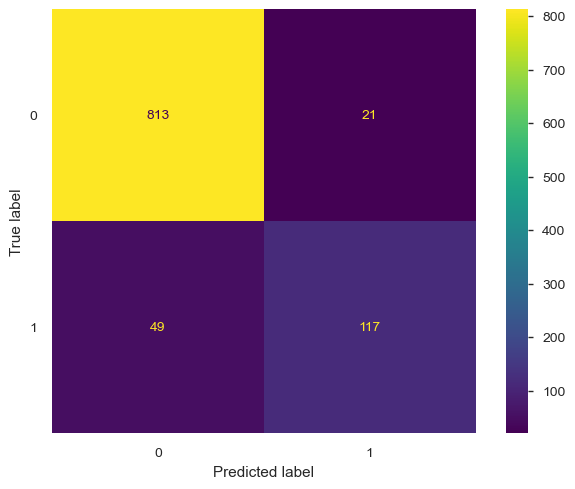

In [56]:
#from sklearn.metrics import plot_confusion_matrix


# Se genera la matriz de confusión
confusion_matrix(y_test, y_pred)
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)  
plt.show()  

In [57]:
#p = pipeline['model'].coef_
#for i in range(0, len(lista_de_palabras_entrenamiento)):
    #print(lista_de_palabras_entrenamiento[i] + " : "+p.get(i))
#pd.DataFrame({'columns': lista_de_palabras_entrenamiento, 'coef': pipeline['model'].coef_})
pipeline['model'].coef_.size

63897

In [58]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[811  23]
 [ 52 114]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       834
           1       0.83      0.69      0.75       166

    accuracy                           0.93      1000
   macro avg       0.89      0.83      0.85      1000
weighted avg       0.92      0.93      0.92      1000



C:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


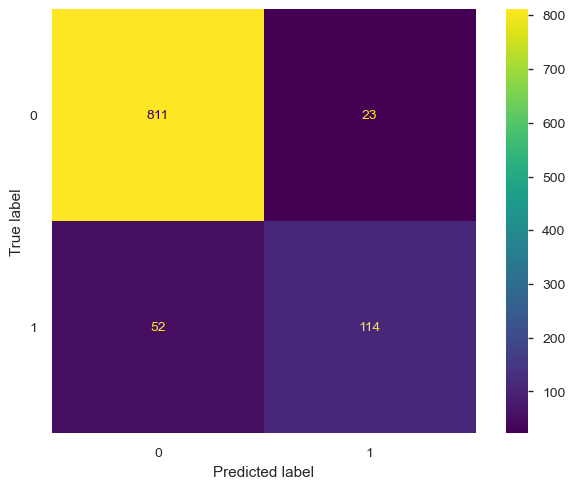

In [77]:
confusion_matrix(y_test, y_pred)
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(svm, X_test, y_test)  
plt.show() 

In [60]:
#svm.coef_
lista =[]
for i in svm.coef_:
    lista.append(i)
    
print(lista)

[<1x21299 sparse matrix of type '<class 'numpy.float64'>'
	with 14051 stored elements in Compressed Sparse Row format>]


In [61]:
coeficientes = svm.coef_[0]
dense_matrix = np.array(coeficientes.todense())

# Obtener una lista nativa de Python a partir de la matriz densa
native_list = dense_matrix.tolist()
lalista = native_list[0]

In [78]:
y_pred = svm.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.93


In [62]:
#lista_positiva = [abs(numero) for numero in lalista]

In [64]:
# Obtener los coeficientes y ordenarlos en orden descendente

# Crear un DataFrame con los coeficientes y los nombres de las características
df_coeficientes = pd.DataFrame({"coeficientes": lalista, "caracteristicas": lista_de_palabras_entrenamiento})

# Ordenar el DataFrame por los coeficientes en orden descendente
df_coeficientes = df_coeficientes.sort_values(by="coeficientes", ascending=False)

# Imprimir los 10 atributos de mayor peso
print("Atributos de mayor peso:")
print(df_coeficientes.head(50))


Atributos de mayor peso:
       coeficientes caracteristicas
19079      2.059576            suci
15347      1.769692           pesim
14777      1.725393           pared
19086      1.558407           sucio
15353      1.342498          pesimo
10390      1.301082          horror
17889      1.246254           saban
7402       1.238269       educacion
12227      1.164948          llegar
5764       1.132404       cucaracha
5763       1.132404        cucarach
6311       1.121134             des
12583      1.102125        malisimo
12581      1.101712         malisim
15143      1.094794         pequena
9215       1.087370             fot
9216       1.087370            foto
6067       1.070857           decir
17806      1.066935             rot
7198       1.064190      doscientos
14591      1.059720             pag
3754       1.058942             car
11433      1.056681           jabon
12546      1.053405             mal
3121       1.029723         booking
6121       1.028140       deficient
135

In [65]:
# Obtener los coeficientes y ordenarlos en orden descendente

# Crear un DataFrame con los coeficientes y los nombres de las características
df_coeficientes = pd.DataFrame({"coeficientes": lalista, "caracteristicas": lista_de_palabras_entrenamiento})

# Ordenar el DataFrame por los coeficientes en orden descendente
df_coeficientes = df_coeficientes.sort_values(by="coeficientes", ascending=True)

# Imprimir los 10 atributos de mayor peso
print("Atributos de mayor peso:")
print(df_coeficientes.head(50))


Atributos de mayor peso:
       coeficientes caracteristicas
12124     -2.132645          limpio
12104     -1.678751           limpi
4798      -1.531703           comod
15300     -1.345585        personal
11442     -1.322479            jaen
1614      -1.281776          amplio
15205     -1.275945         perfect
8625      -1.274339        excelent
8627      -1.267876       excelente
1606      -1.253103           ampli
15209     -1.230904        perfecto
7257      -1.208743             dud
9586      -1.208330          genial
1506      -1.204055           amabl
20270     -1.159329       ubicacion
7653      -1.158799          encant
20056     -1.156584       tranquilo
8329      -1.131726        estacion
21122     -1.127341            wifi
20036     -1.092655        tranquil
5735      -1.056165        cuarenta
14802     -1.020268         parking
980       -1.007709       agradable
13423     -1.002270         monitor
977       -0.992397           agrad
7263      -0.988900           dudar
127

C:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


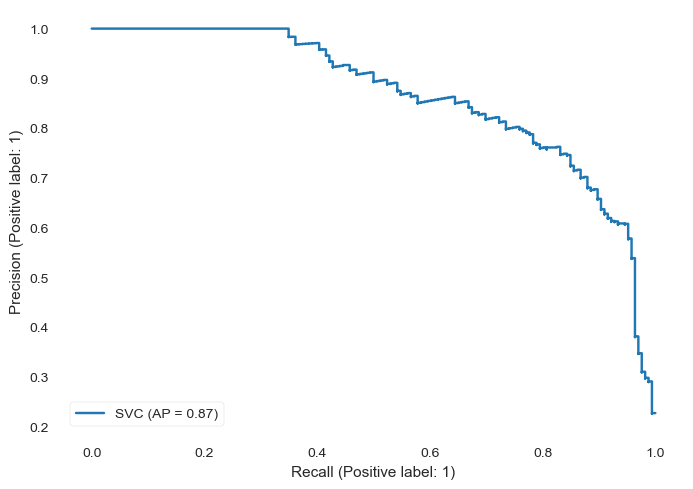

In [66]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(svm, X_test, y_test)
plt.show()

In [67]:
from sklearn.tree import DecisionTreeClassifier
# Train a decision tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [68]:
# Predict on the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.87


C:\Users\diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


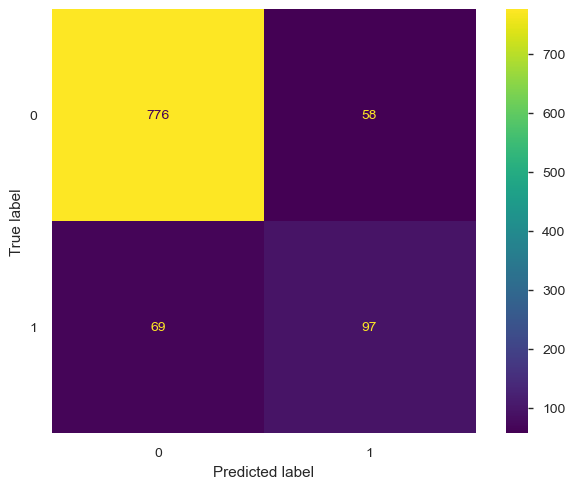

In [69]:
#from sklearn.metrics import plot_confusion_matrix

# Se genera la matriz de confusión
confusion_matrix(y_test, y_pred)
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()  

In [70]:
# Mostrar reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       834
           1       0.63      0.58      0.60       166

    accuracy                           0.87      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.87      0.87      0.87      1000



In [71]:
# Obtener la importancia de cada atributo
importancia_atributos = clf.feature_importances_

# Crear un dataframe con los nombres de los atributos y su importancia
datos_atributos = {'Atributo': lista_de_palabras_entrenamiento, 'Importancia': importancia_atributos}
df_atributos = pd.DataFrame(datos_atributos)

# Ordenar los atributos por importancia descendente
df_atributos_ordenados = df_atributos.sort_values('Importancia', ascending=False)

# Imprimir los 10 atributos más importantes
print(df_atributos_ordenados.head(50))

         Atributo  Importancia
19079        suci     0.088874
12546         mal     0.054483
15347       pesim     0.048254
14591         pag     0.028224
6067        decir     0.018498
14777       pared     0.016993
16819   recepcion     0.015368
12124      limpio     0.013136
12227      llegar     0.012732
10437       hotel     0.011766
6926        diner     0.011340
6121    deficient     0.010861
10390      horror     0.010624
11820  lamentable     0.010390
12581     malisim     0.009353
12189        llam     0.009104
12619       manch     0.009027
9215          fot     0.008789
13794     nefasto     0.008339
6385     desayuno     0.008152
15142      pequen     0.007944
6858    dieciocho     0.007484
980     agradable     0.007478
6311          des     0.007435
11463         jam     0.007408
11170    insoport     0.007381
18892    sorpresa     0.007364
5764    cucaracha     0.007346
3806      carisim     0.007328
19566        teni     0.006921
4880      complet     0.006888
17400   

In [73]:
# Obtener la importancia de cada atributo
importancia_atributos = clf.feature_importances_

# Crear un dataframe con los nombres de los atributos y su importancia
datos_atributos = {'Atributo': lista_de_palabras_entrenamiento, 'Importancia': importancia_atributos}
df_atributos = pd.DataFrame(datos_atributos)

# Ordenar los atributos por importancia descendente
df_atributos_ordenados = df_atributos.sort_values('Importancia', ascending=True)

# Imprimir los 10 atributos más importantes
print(df_atributos_ordenados.head(50))

               Atributo  Importancia
0                  0000          0.0
14172             ocean          0.0
14171           ocasión          0.0
14170         ocasional          0.0
14169           ocasion          0.0
14168         obviously          0.0
14167             obvio          0.0
14166          obviedad          0.0
14173            oceano          0.0
14165            obvied          0.0
14163        obviamente          0.0
14162              obvi          0.0
14161           obtuvir          0.0
14160             obtuv          0.0
14159            obtién          0.0
14158            obtien          0.0
14157           obtener          0.0
14164            obviar          0.0
14174               och          0.0
14175           ochaber          0.0
14176              oche          0.0
14193            ocupab          0.0
14192              ocup          0.0
14191               ocu          0.0
14190          octubrey          0.0
14189           octubre          0.0
1

In [74]:
filename = 'modelogreg.joblib'

In [75]:
from joblib import dump, load

In [76]:
dump(pipeline, filename)

['modelogreg.joblib']